# Strategy Horizontal Comparison
This is for all strategy to horizontal comparison, and with same input and same assets

2023-11-08 18:24:10,806 - INFO - start load files from 2023-08-13 to 2023-08-16...
2023-11-08 18:24:10,869 - INFO - load file complete, preparing...
2023-11-08 18:24:11,116 - INFO - data has been prepared
2023-11-08 18:24:11,126 - INFO - init strategy...
2023-11-08 18:24:11,129 - INFO - init strategy: NoProvisionStrategy
2023-11-08 18:24:11,131 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:04<00:00, 1169.26it/s]
2023-11-08 18:24:16,064 - INFO - main loop finished
2023-11-08 18:24:16,108 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:16,128 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:16,129 - INFO - Print actuator summary
2023-11-08 18:24:16,136 - INFO - Backtesting finished, execute time 5.01157021522522s
2023-11-08 18:24:16,183 - INFO - files have saved to ./result/backtest-20231108-182416.account.csv,./result/backtest-20231108-1824

Final account status                              
Token balance in broker       
USDC      :1800                     ETH       :1                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
Empty DataFrame


Account balance history                           
                                         net_value  USDC ETH uni_market_net_value uni_market_base_uncollected uni_market_quote_uncollected uni_market_base_in_position uni_market_quote_in_position  uni_market_position_count
2023-08-13 00:00:00  3648.124377723789062528919544  1800   1                0E-24                           0                            0                           0                            0                          0
2023-08-13 00:01:00  3648.124377723789062528919544  1800   1                0E-24                           0          

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


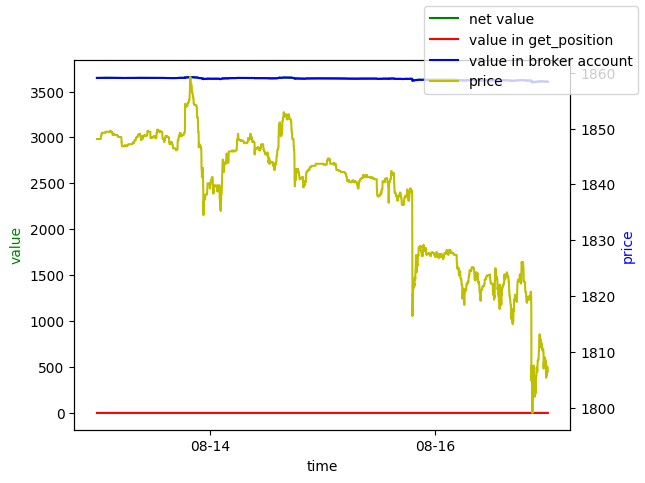

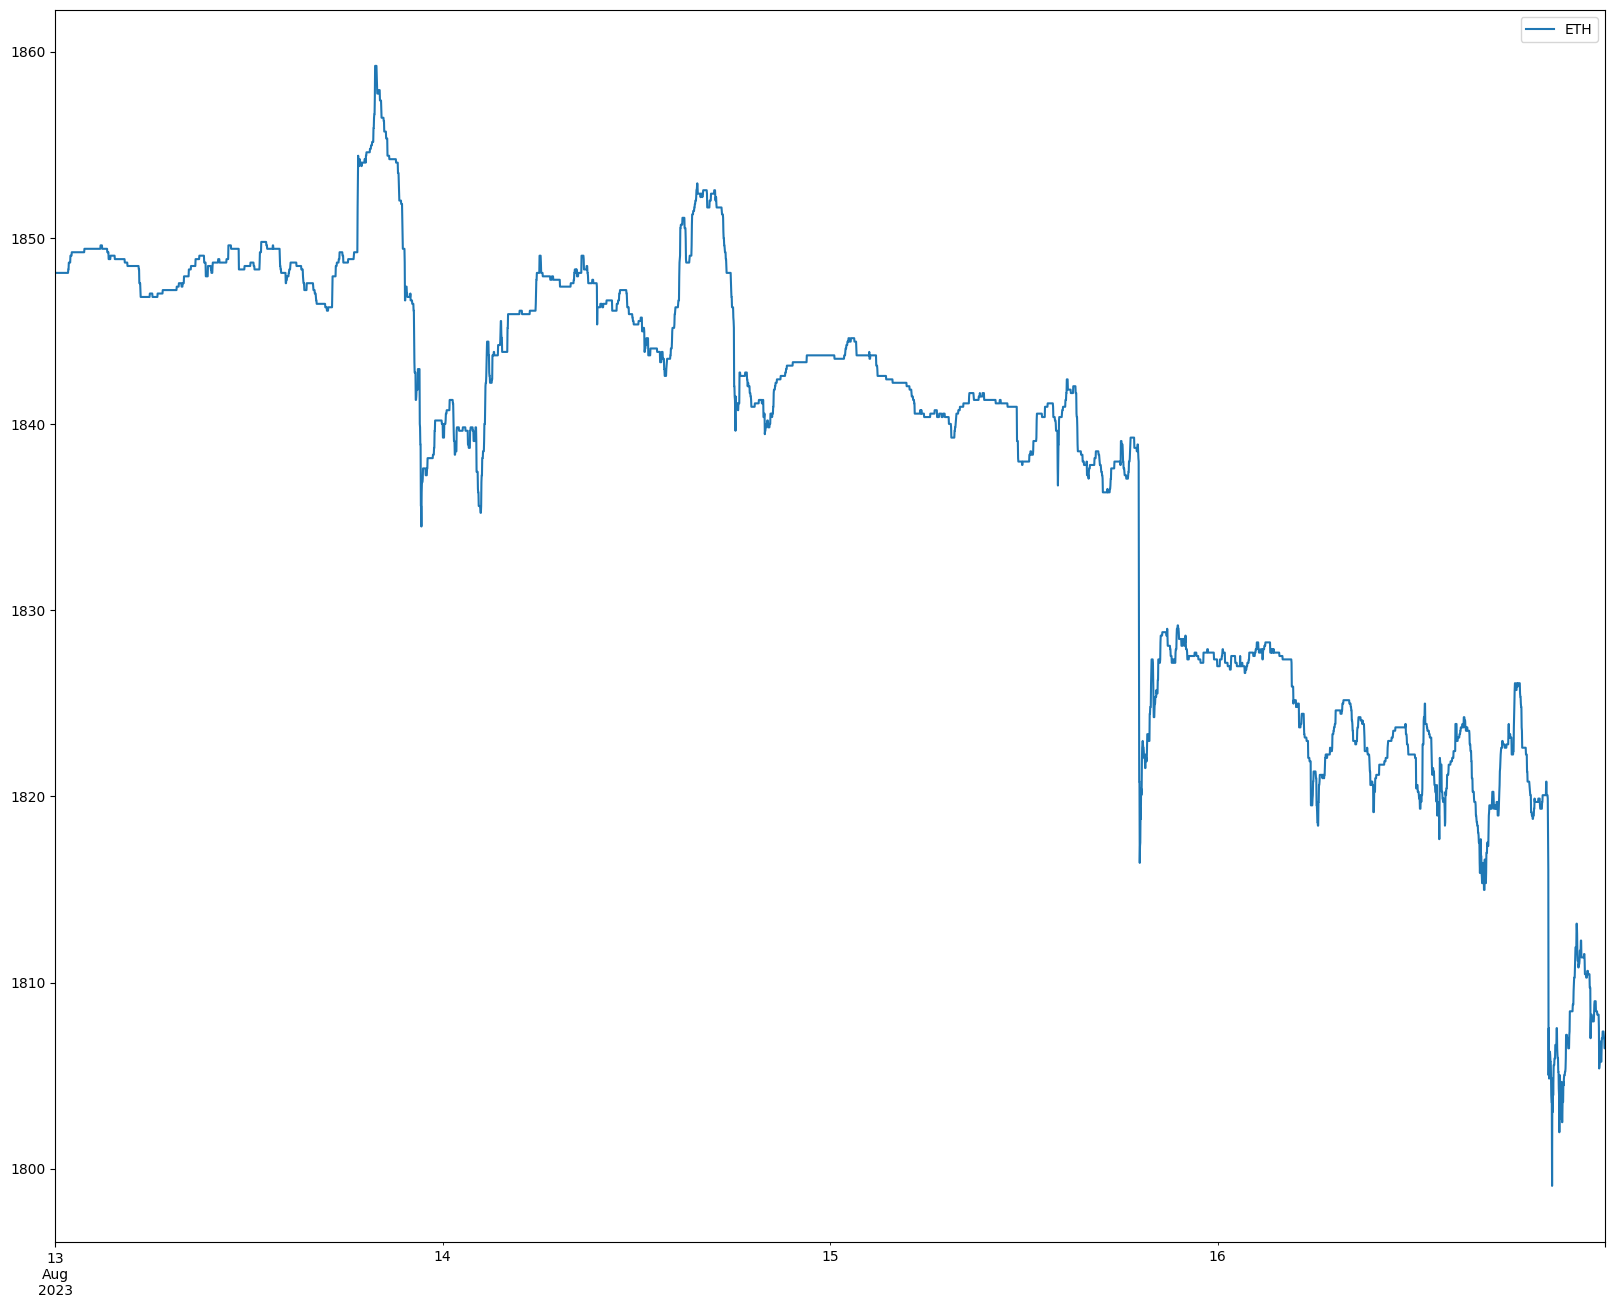

2023-11-08 18:24:17,106 - INFO - init strategy...
2023-11-08 18:24:17,175 - INFO - init strategy: UniswapV2Strategy
2023-11-08 18:24:17,176 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1616.94it/s]
2023-11-08 18:24:20,747 - INFO - main loop finished
2023-11-08 18:24:20,790 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:20,845 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:20,846 - INFO - Print actuator summary
2023-11-08 18:24:20,854 - INFO - Backtesting finished, execute time 3.7491488456726074s
2023-11-08 18:24:20,926 - INFO - files have saved to ./result/backtest-20231108-182420.account.csv,./result/backtest-20231108-182420.action.json,./result/backtest-20231108-182420.action.pkl


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.0260395773703776832599393276
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                         pending0                            pending1       liquidity
0     -887272      887272  0.07987493141839941656270998797  0.00005083198964910390183525308047  41870380470367

Account balance history                           
                                         net_value USDC                             ETH           uni_market_net_value      uni_market_base_uncollected        uni_market_quote_uncollected    uni_market_base_in_position    uni_market_quote_in_position  uni_market_position_count
2023-08-13 00:00:00  3648.124394982263713698890056    0  0.026039577370377683

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


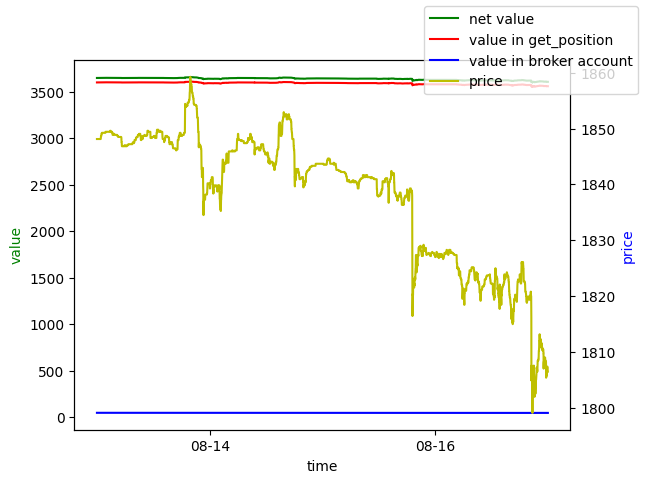

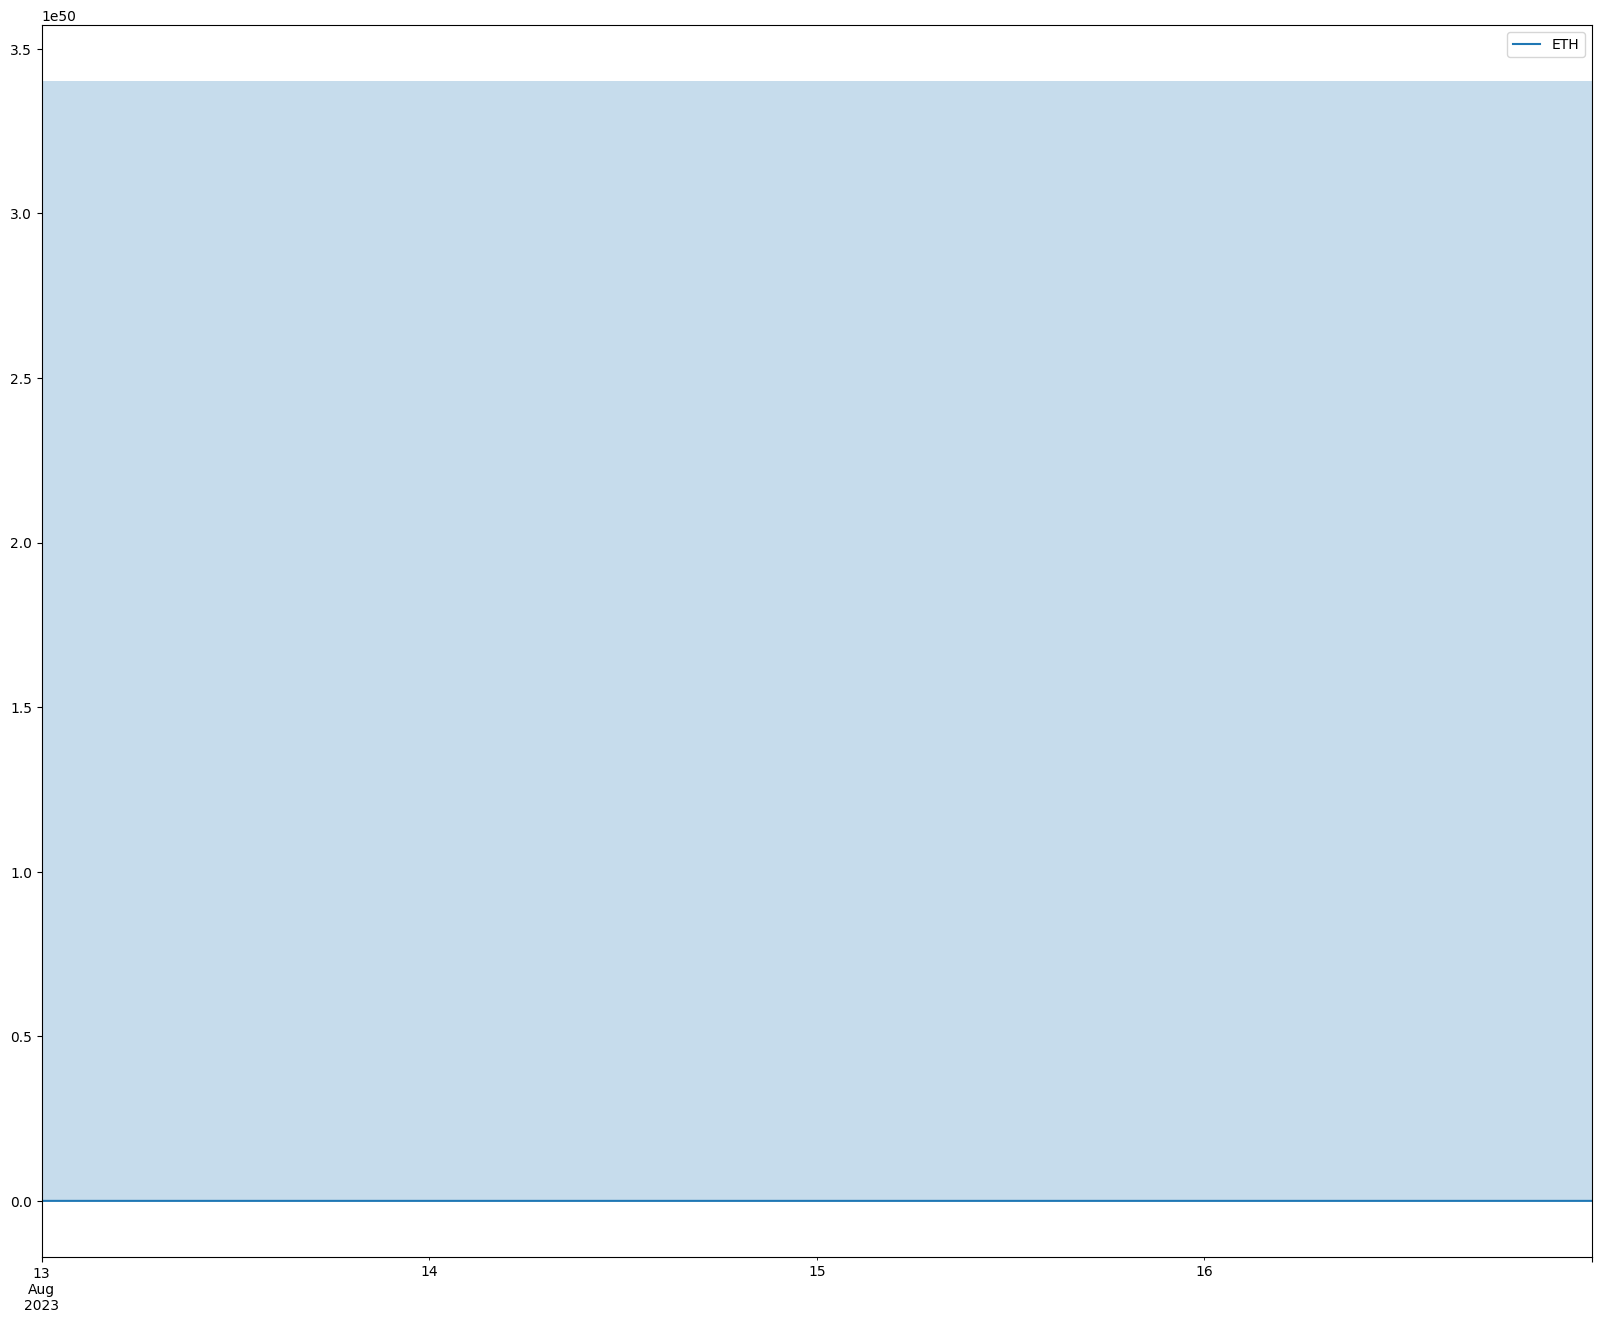

2023-11-08 18:24:21,830 - INFO - init strategy...
2023-11-08 18:24:21,833 - INFO - init strategy: ConstantIntervalStrategy
2023-11-08 18:24:21,836 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:04<00:00, 1345.34it/s]
2023-11-08 18:24:26,121 - INFO - main loop finished
2023-11-08 18:24:26,266 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:26,311 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:26,312 - INFO - Print actuator summary
2023-11-08 18:24:26,323 - INFO - Backtesting finished, execute time 4.493633031845093s
2023-11-08 18:24:26,394 - INFO - files have saved to ./result/backtest-20231108-182426.account.csv,./result/backtest-20231108-182426.action.json,./result/backtest-20231108-182426.action.pkl


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.00243855971009984498251056096
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                          pending0                             pending1       liquidity
0     -887272      887272    0.1597496831018549670339951987    0.0001016638606774799076966759872  41870380470367
1      199141      203540  0.009296202361772704902160727994  0.000005916054191692622433503447822   4873073425749

Account balance history                           
                                         net_value USDC                              ETH           uni_market_net_value      uni_market_base_uncollected        uni_market_quote_uncollected    uni_market_base_in_position    uni_market_quo

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


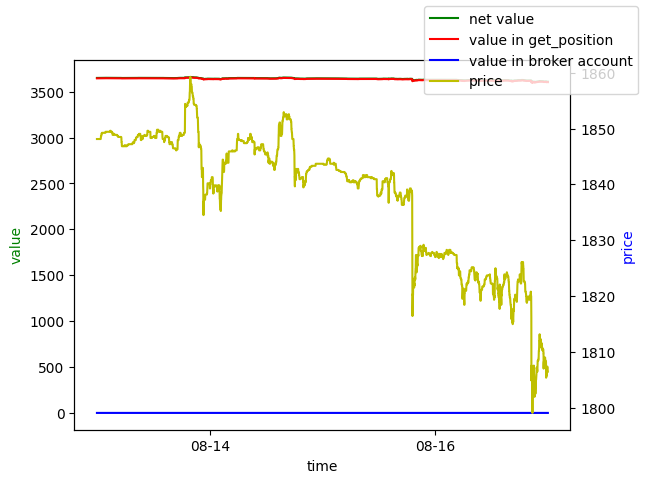

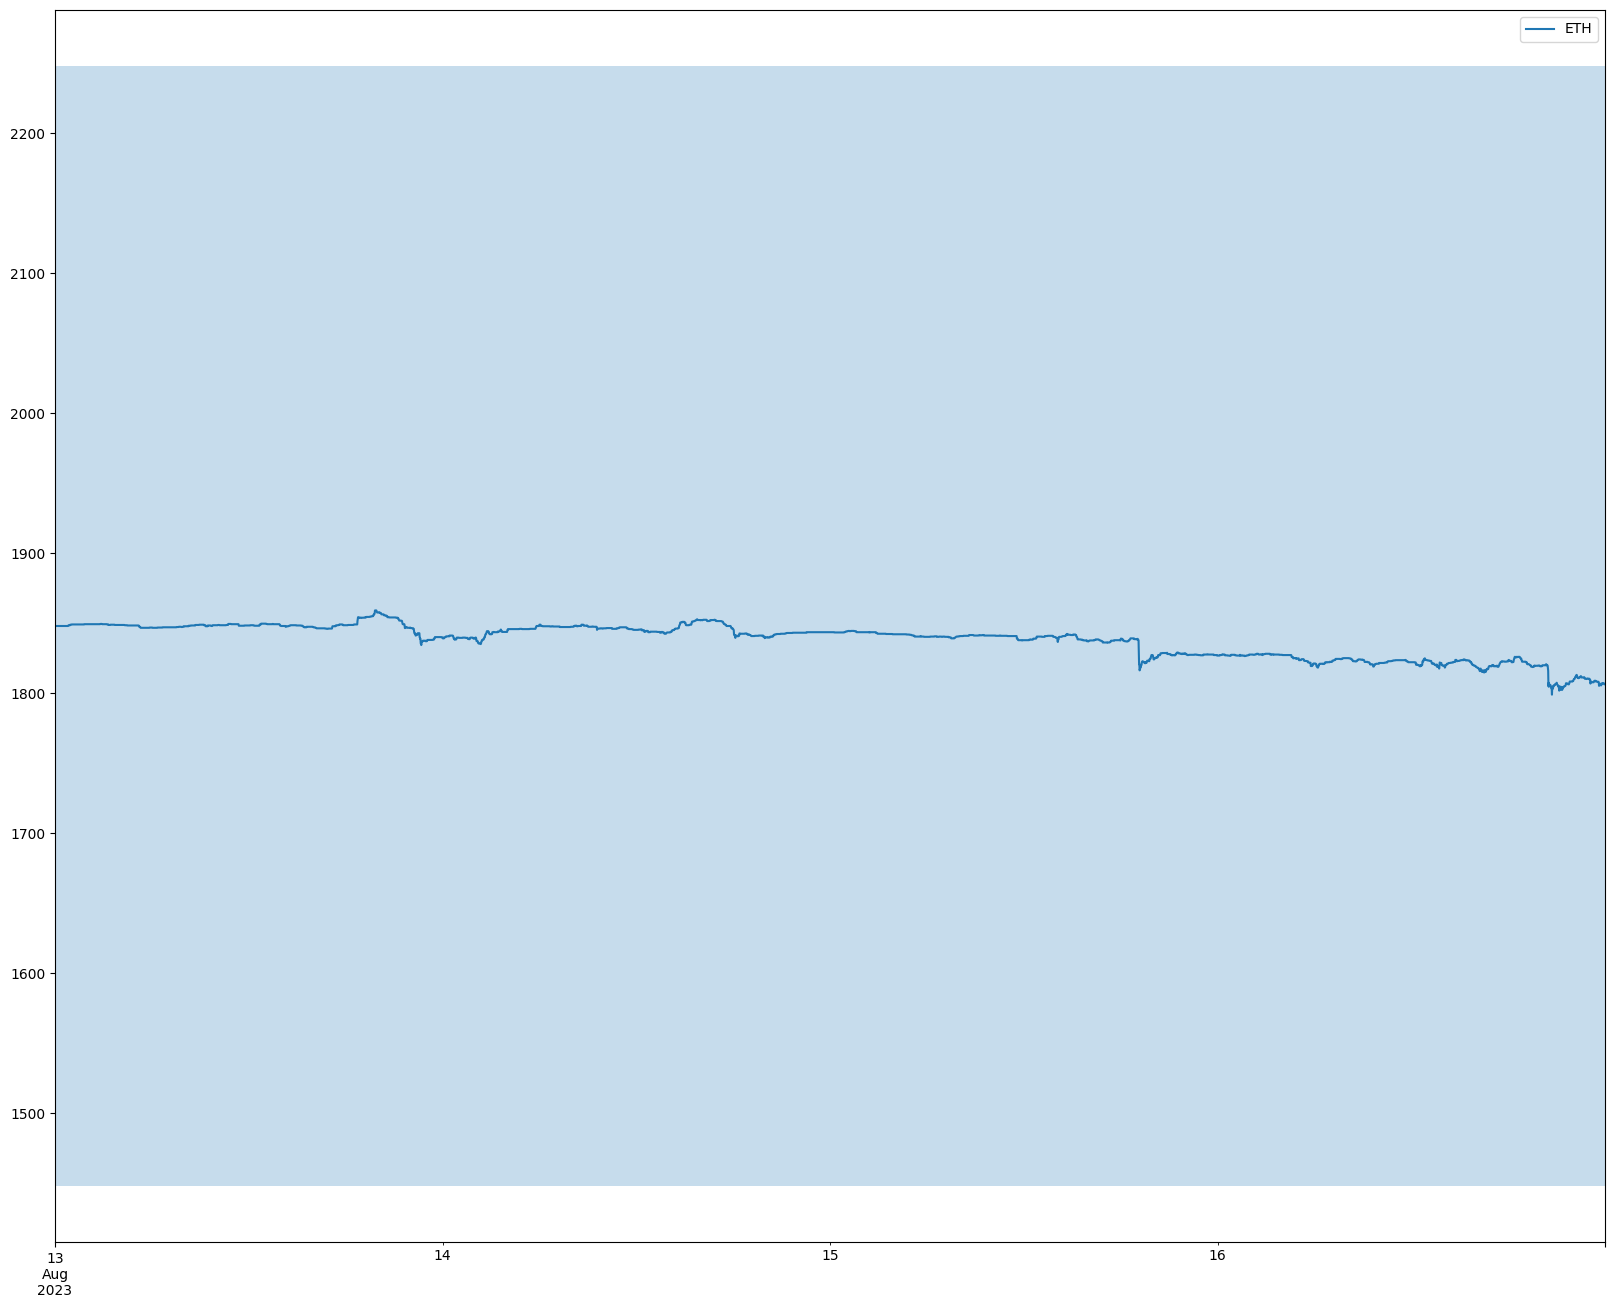

2023-11-08 18:24:27,297 - INFO - init strategy...
2023-11-08 18:24:27,341 - INFO - init strategy: IntervalsAroundtheCurrentPriceStrategy
2023-11-08 18:24:27,344 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1529.33it/s]
2023-11-08 18:24:31,121 - INFO - main loop finished
2023-11-08 18:24:31,168 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:31,224 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:31,224 - INFO - Print actuator summary
2023-11-08 18:24:31,233 - INFO - Backtesting finished, execute time 3.9369499683380127s
2023-11-08 18:24:31,301 - INFO - files have saved to ./result/backtest-20231108-182431.account.csv,./result/backtest-20231108-182431.action.json,./result/backtest-20231108-182431.action.pkl


Final account status                              
Token balance in broker       
USDC      :32.068741731105343828797601ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                       pending0                          pending1          liquidity
0      201161      201270  7.396807924286515255830035762  0.004810715252941465205699517458  15464559714229567

Account balance history                           
                                         net_value                         USDC                              ETH           uni_market_net_value     uni_market_base_uncollected       uni_market_quote_uncollected    uni_market_base_in_position    uni_market_quote_in_position  uni_market_position_count
2023-08-13 00:00:00  3648.480232077625189712417083         

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


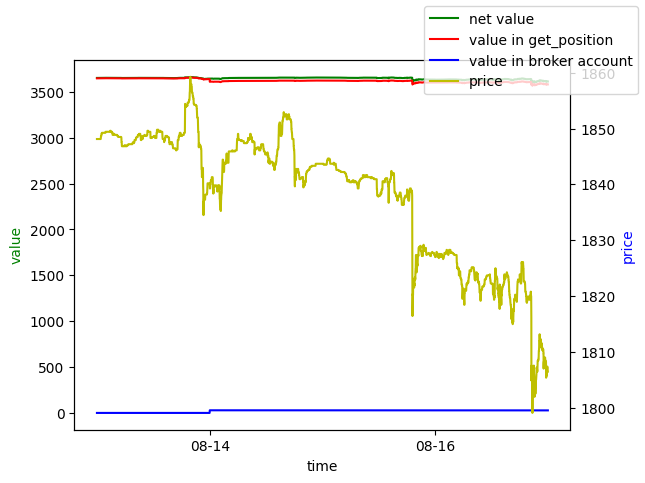

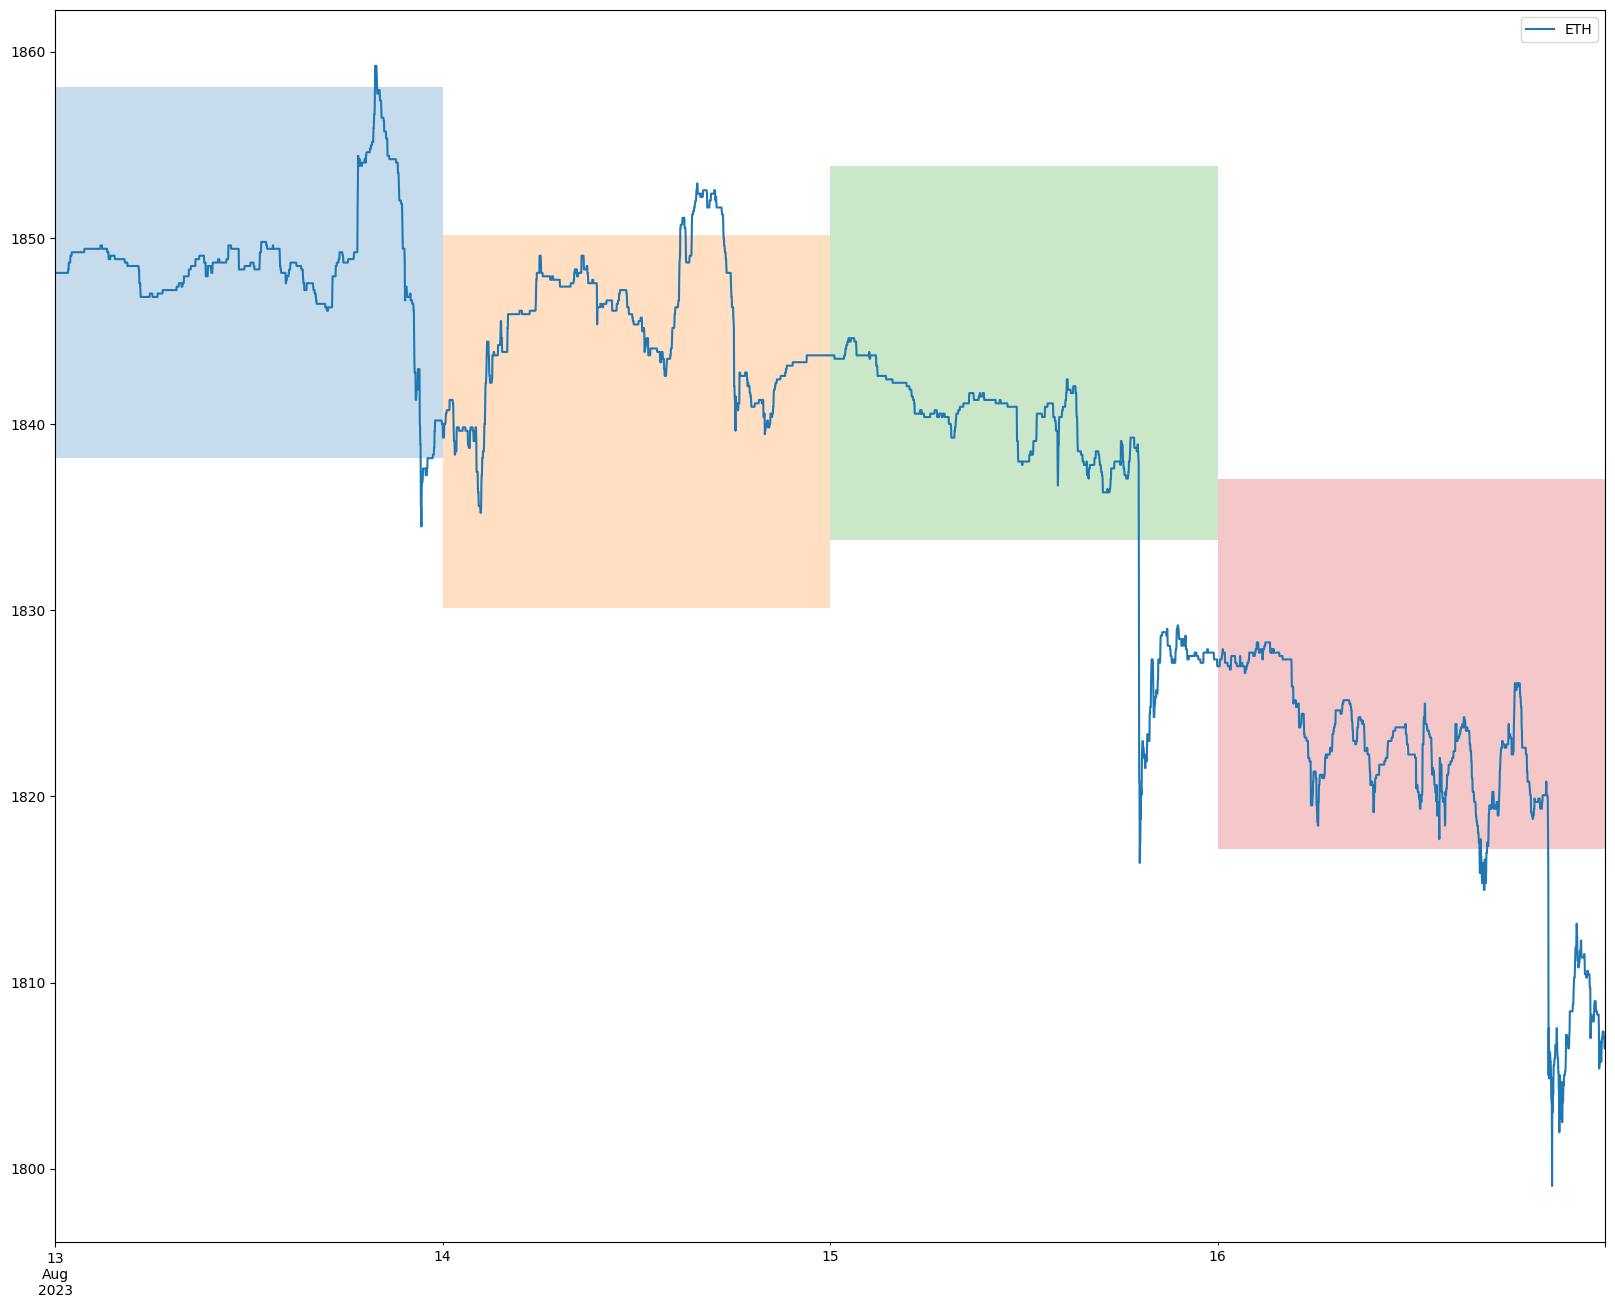

2023-11-08 18:24:32,332 - INFO - init strategy...
2023-11-08 18:24:32,337 - INFO - init strategy: TwoIntervalsAroundtheCurrentPriceStrategy
2023-11-08 18:24:32,339 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1612.43it/s]
2023-11-08 18:24:35,916 - INFO - main loop finished
2023-11-08 18:24:35,960 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:36,012 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:36,013 - INFO - Print actuator summary
2023-11-08 18:24:36,021 - INFO - Backtesting finished, execute time 3.694511890411377s
2023-11-08 18:24:36,086 - INFO - files have saved to ./result/backtest-20231108-182436.account.csv,./result/backtest-20231108-182436.action.json,./result/backtest-20231108-182436.action.pkl


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0.9955657980056476554139840205
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                        pending0                           pending1        liquidity
0      201216      202375  0.6193694166508880749860162488  0.0004035952088625479044442229188  755809478358709

Account balance history                           
                                         net_value USDC                             ETH           uni_market_net_value     uni_market_base_uncollected       uni_market_quote_uncollected    uni_market_base_in_position     uni_market_quote_in_position  uni_market_position_count
2023-08-13 00:00:00  3650.759158453973361331458296    0                         

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


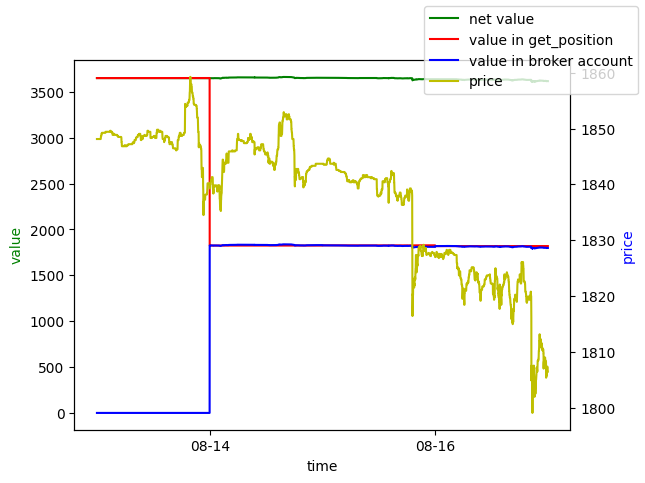

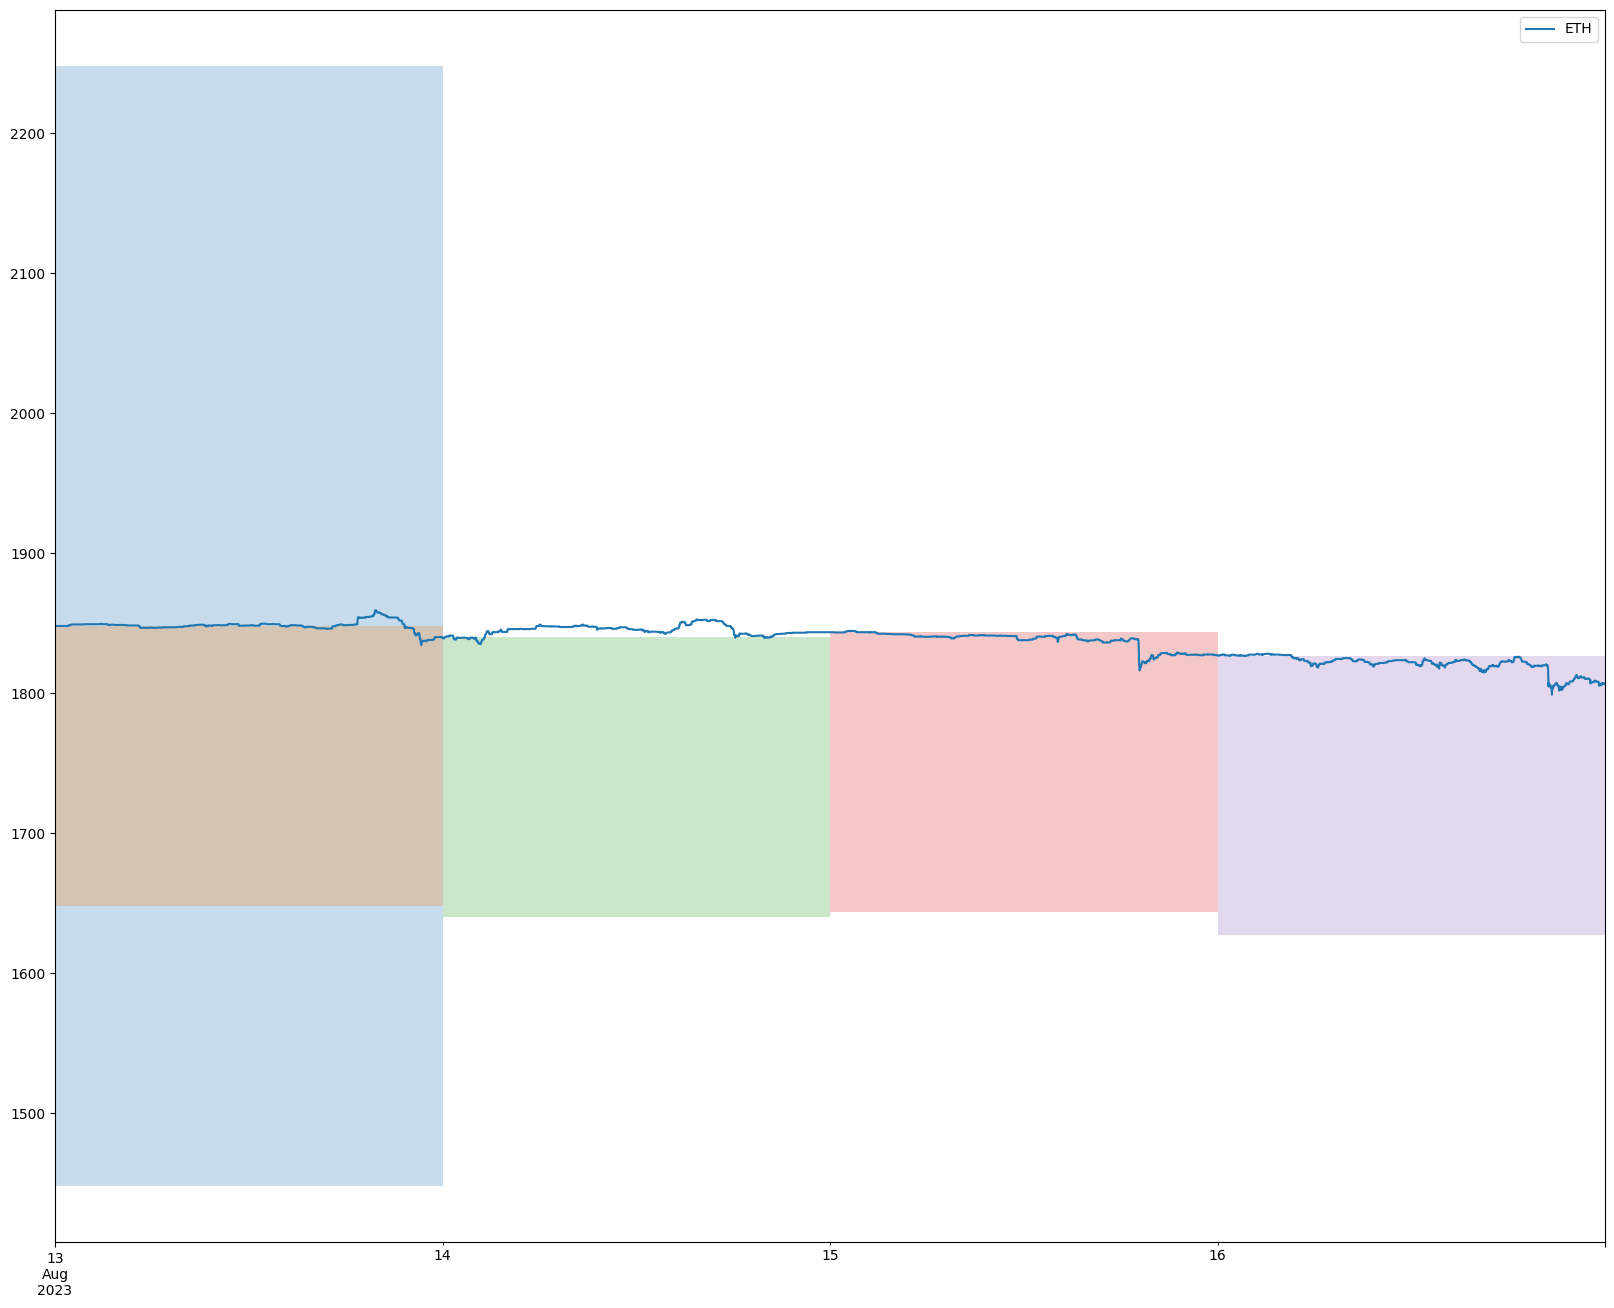

2023-11-08 18:24:36,964 - INFO - init strategy...
2023-11-08 18:24:36,967 - INFO - init strategy: FillUpStrategy
2023-11-08 18:24:36,968 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1472.56it/s]
2023-11-08 18:24:40,883 - INFO - main loop finished
2023-11-08 18:24:40,929 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:40,984 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:40,985 - INFO - Print actuator summary
2023-11-08 18:24:40,993 - INFO - Backtesting finished, execute time 4.029687881469727s
2023-11-08 18:24:41,055 - INFO - files have saved to ./result/backtest-20231108-182440.account.csv,./result/backtest-20231108-182440.action.json,./result/backtest-20231108-182440.action.pkl


Final account status                              
Token balance in broker       
USDC      :0                        ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                        pending0                            pending1          liquidity
0      201161      201270   7.430313097723304561925192460    0.004832470538726813053561439398  15536973450426983
1      201216      201270  0.1173068013294406224863732799  0.00007784635696698814179404020955    279424336539559

Account balance history                           
                                         net_value USDC ETH           uni_market_net_value     uni_market_base_uncollected       uni_market_quote_uncollected    uni_market_base_in_position    uni_market_quote_in_position  uni_market_position_c

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


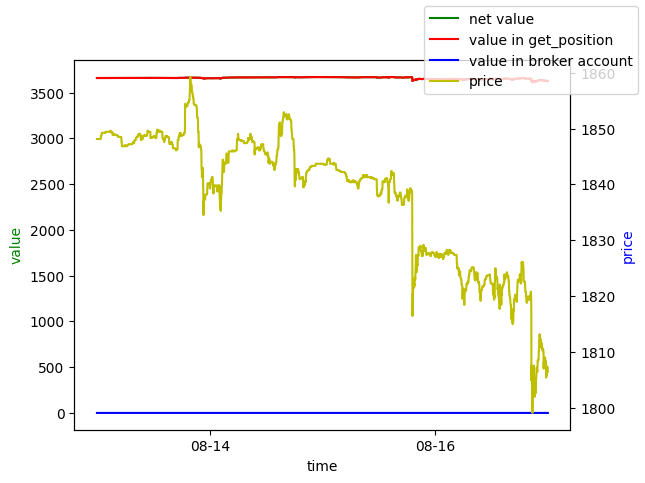

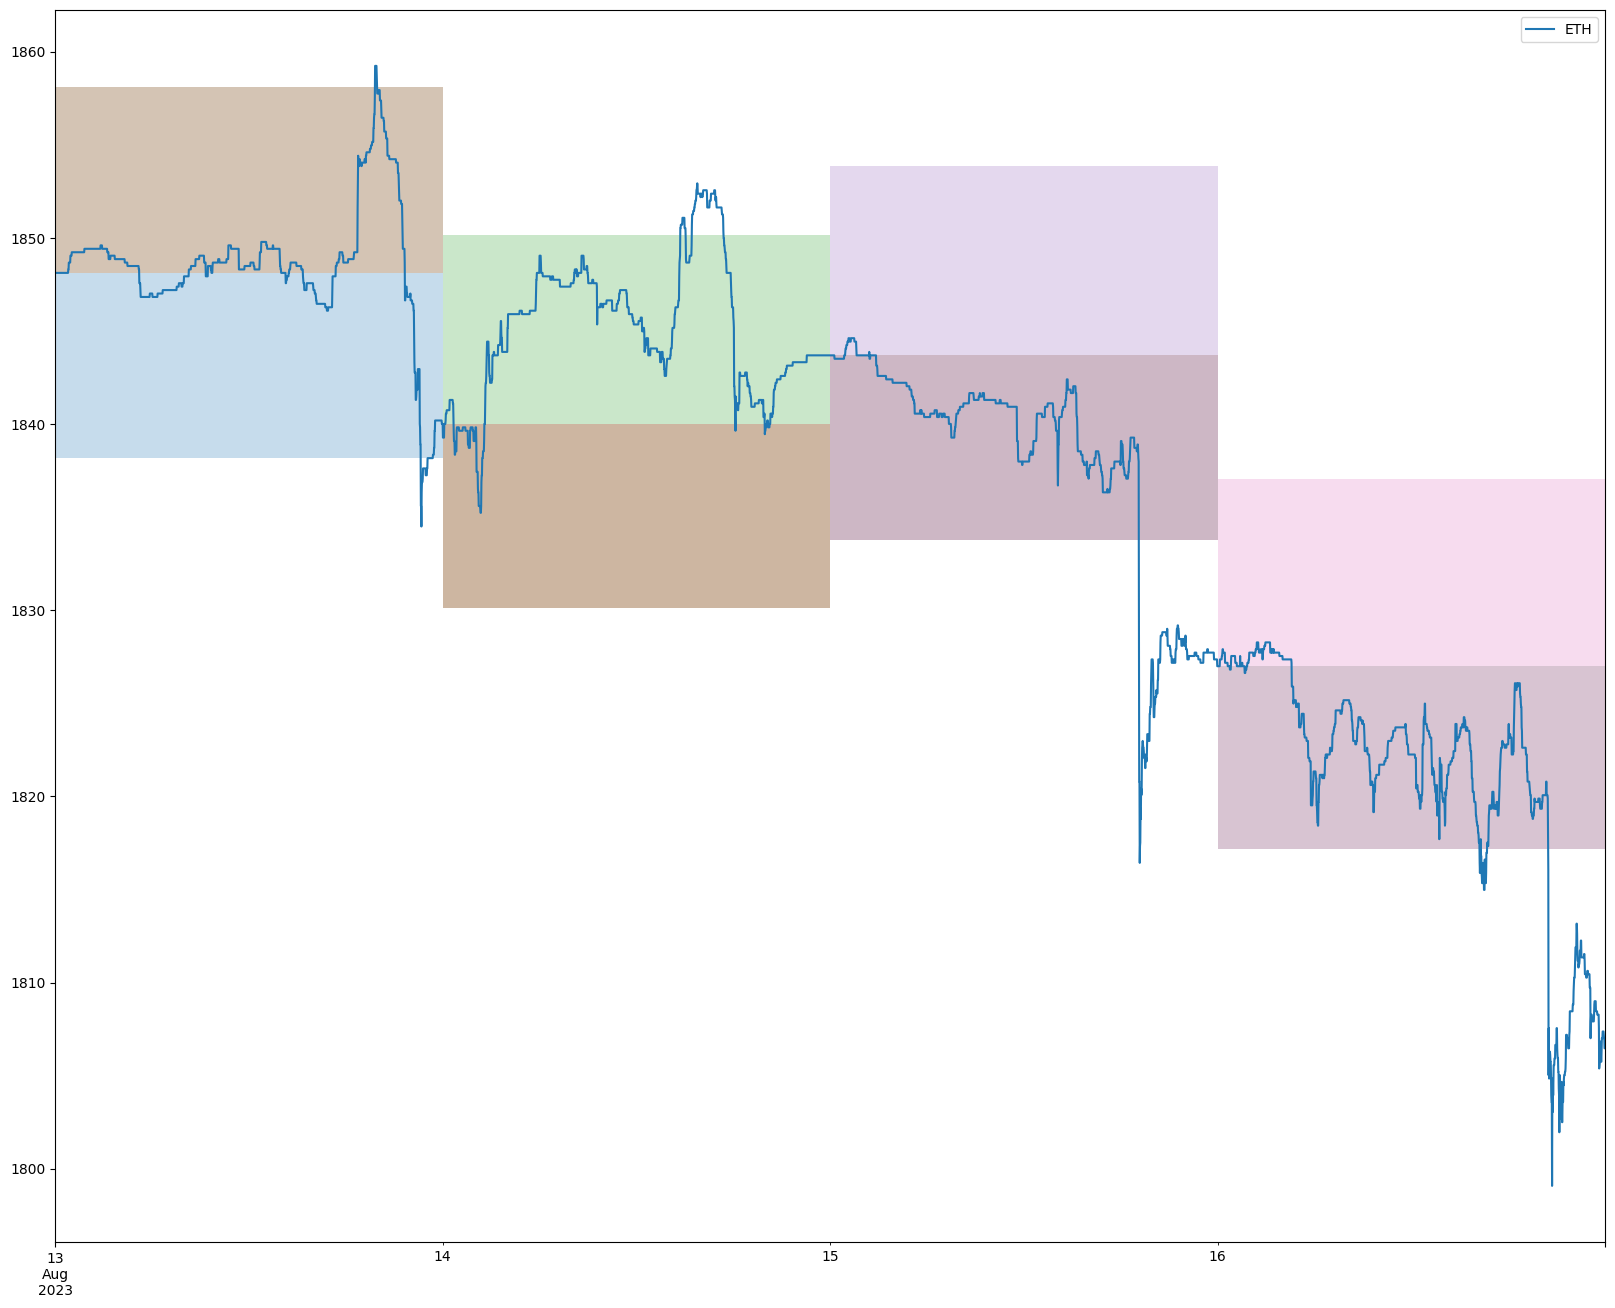

2023-11-08 18:24:42,451 - INFO - init strategy...
2023-11-08 18:24:42,455 - INFO - init strategy: MovingAverageStrategy
2023-11-08 18:24:42,463 - INFO - start main loop...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:05<00:00, 966.38it/s]
2023-11-08 18:24:48,430 - INFO - main loop finished
2023-11-08 18:24:48,528 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:48,635 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:48,636 - INFO - Print actuator summary
2023-11-08 18:24:48,651 - INFO - Backtesting finished, execute time 6.201748847961426s
2023-11-08 18:24:48,775 - INFO - files have saved to ./result/backtest-20231108-182448.account.csv,./result/backtest-20231108-182448.action.json,./result/backtest-20231108-182448.action.pkl


Final account status                              
Token balance in broker       
USDC      :9.722372259476017290094917ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                        pending0                           pending1         liquidity
0      200709      201808  0.8170795385531990090176054223  0.0005277785215523796656157138864  1570715970596414

Account balance history                           
                                         net_value                        USDC                             ETH           uni_market_net_value     uni_market_base_uncollected       uni_market_quote_uncollected    uni_market_base_in_position    uni_market_quote_in_position  uni_market_position_count
2023-08-13 00:00:00  3667.184354279713707144390854          

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


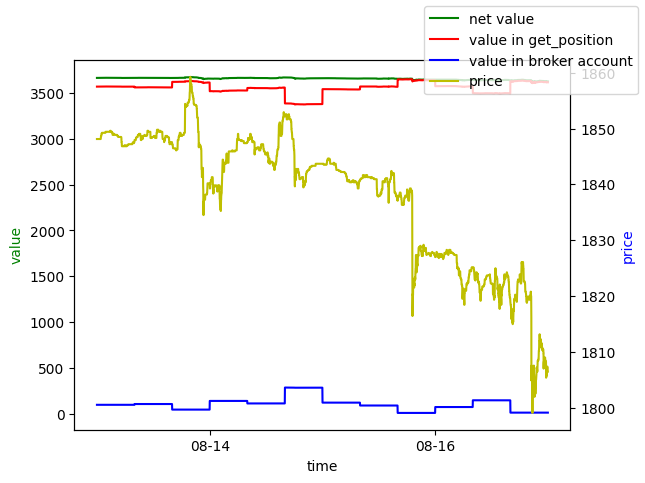

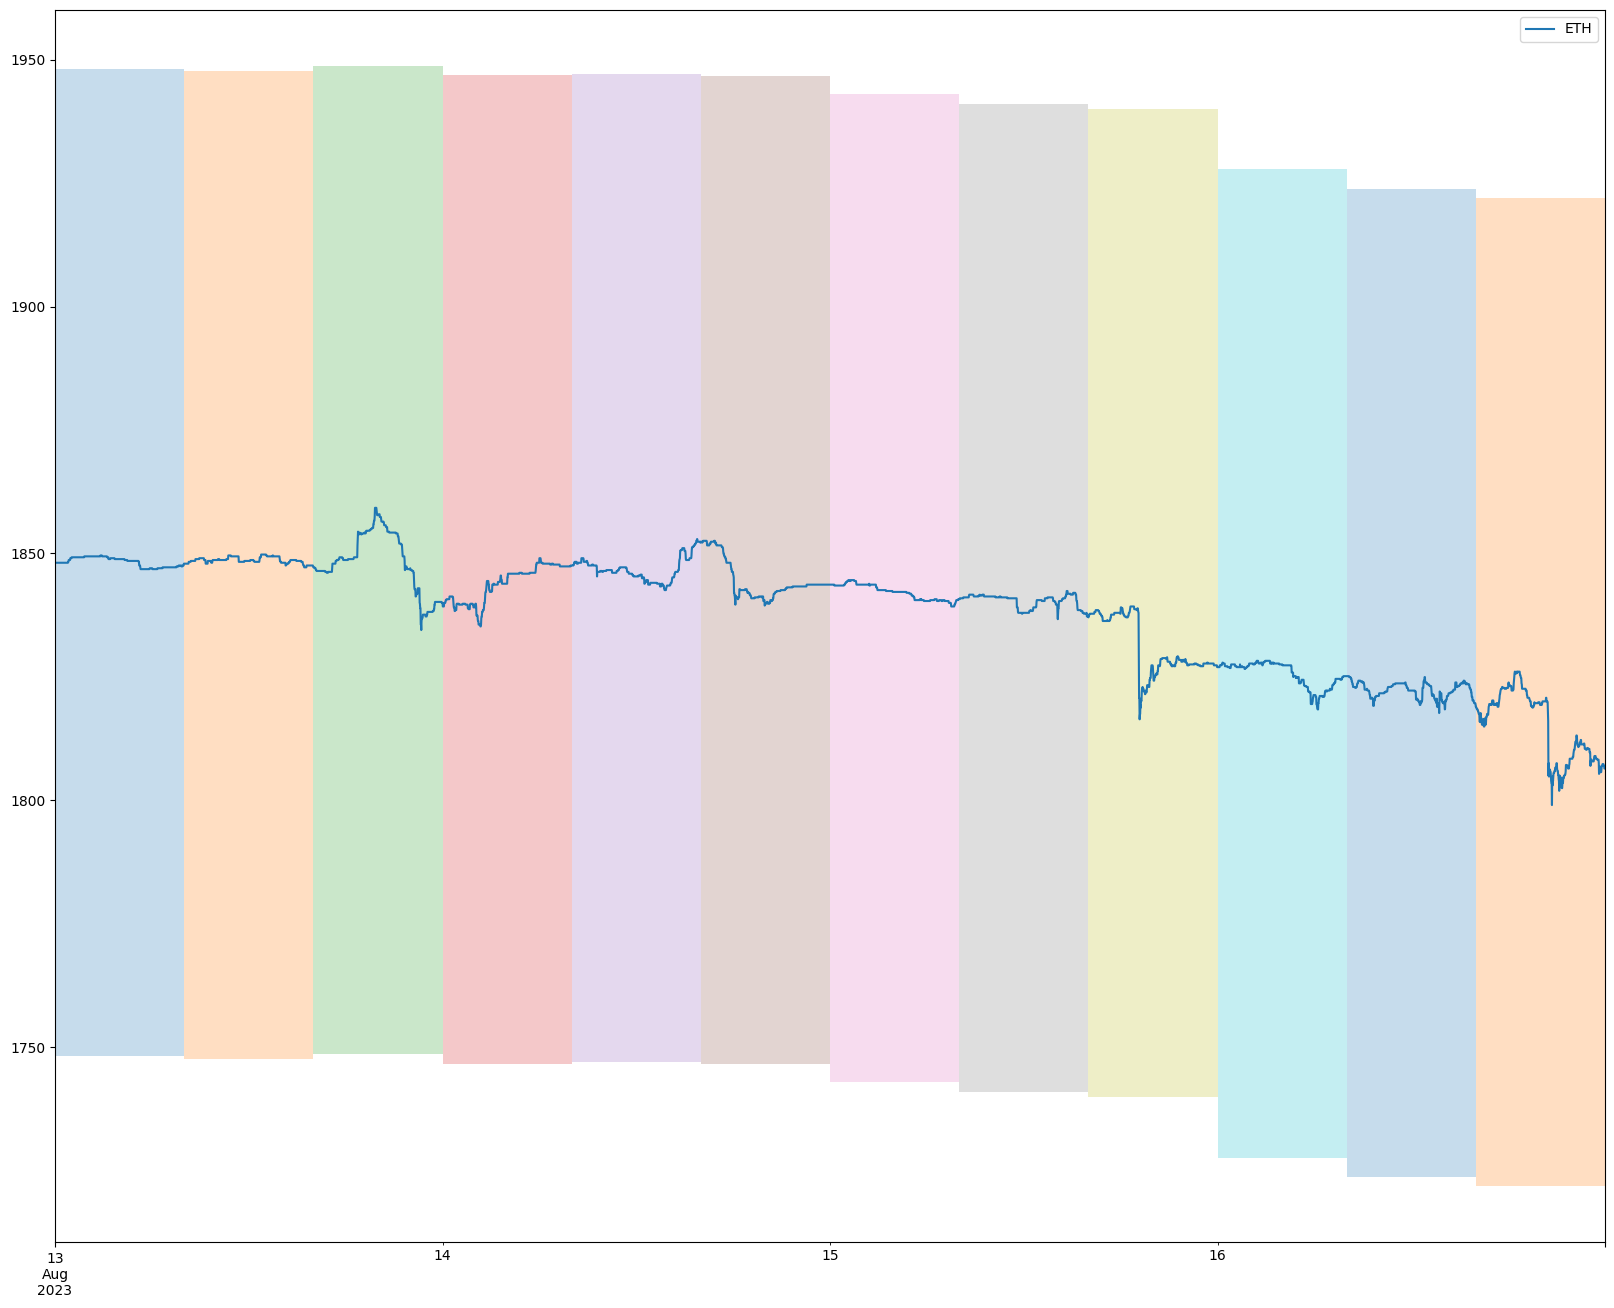

2023-11-08 18:24:50,151 - INFO - init strategy...
2023-11-08 18:24:50,155 - INFO - init strategy: BollingerBrandsStrategy
2023-11-08 18:24:50,291 - INFO - start main loop...
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 5760/5760 [00:03<00:00, 1611.53it/s]
2023-11-08 18:24:53,870 - INFO - main loop finished
2023-11-08 18:24:53,913 - INFO - Start calculate evaluating indicator...
2023-11-08 18:24:53,967 - INFO - Evaluating indicator has finished it's job.
2023-11-08 18:24:53,967 - INFO - Print actuator summary
2023-11-08 18:24:53,977 - INFO - Backtesting finished, execute time 3.8261260986328125s
2023-11-08 18:24:54,049 - INFO - files have saved to ./result/backtest-20231108-182453.account.csv,./result/backtest-20231108-182453.action.json,./result/backtest-20231108-182453.action.pkl


Final account status                              
Token balance in broker       
USDC      :720.465739577396477362343648ETH       :0                        
Position value in markets     
uni_market(UniLpMarket)
token0    :USDC                     token1    :ETH                      fee       :0.0500                   is 0 base :True                     
positions 
   lower_tick  upper_tick                        pending0                          pending1          liquidity
0      201215      201284  0.8461487754380391308176240894  0.001459405332664573432805087288  19907138152046245

Account balance history                           
                                         net_value                           USDC                             ETH           uni_market_net_value     uni_market_base_uncollected      uni_market_quote_uncollected uni_market_base_in_position   uni_market_quote_in_position  uni_market_position_count
2023-08-13 00:00:00  3666.977747400576052318783695  1833.359

/var/folders/n6/c_55zk7d3nqb3jhk31yv_60r0000gn/T/ipykernel_36437/2129790781.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


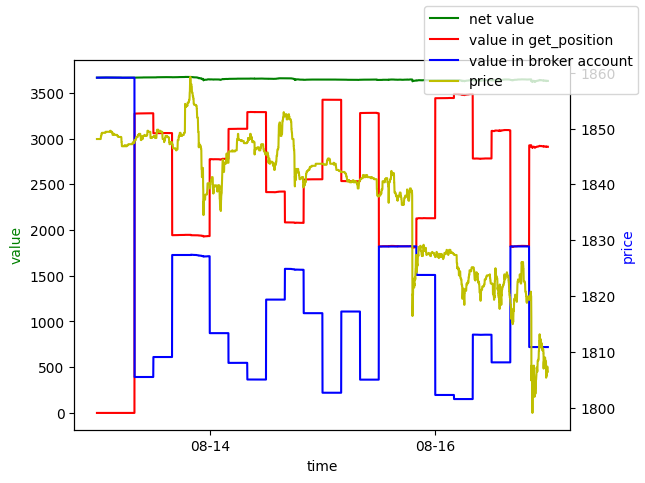

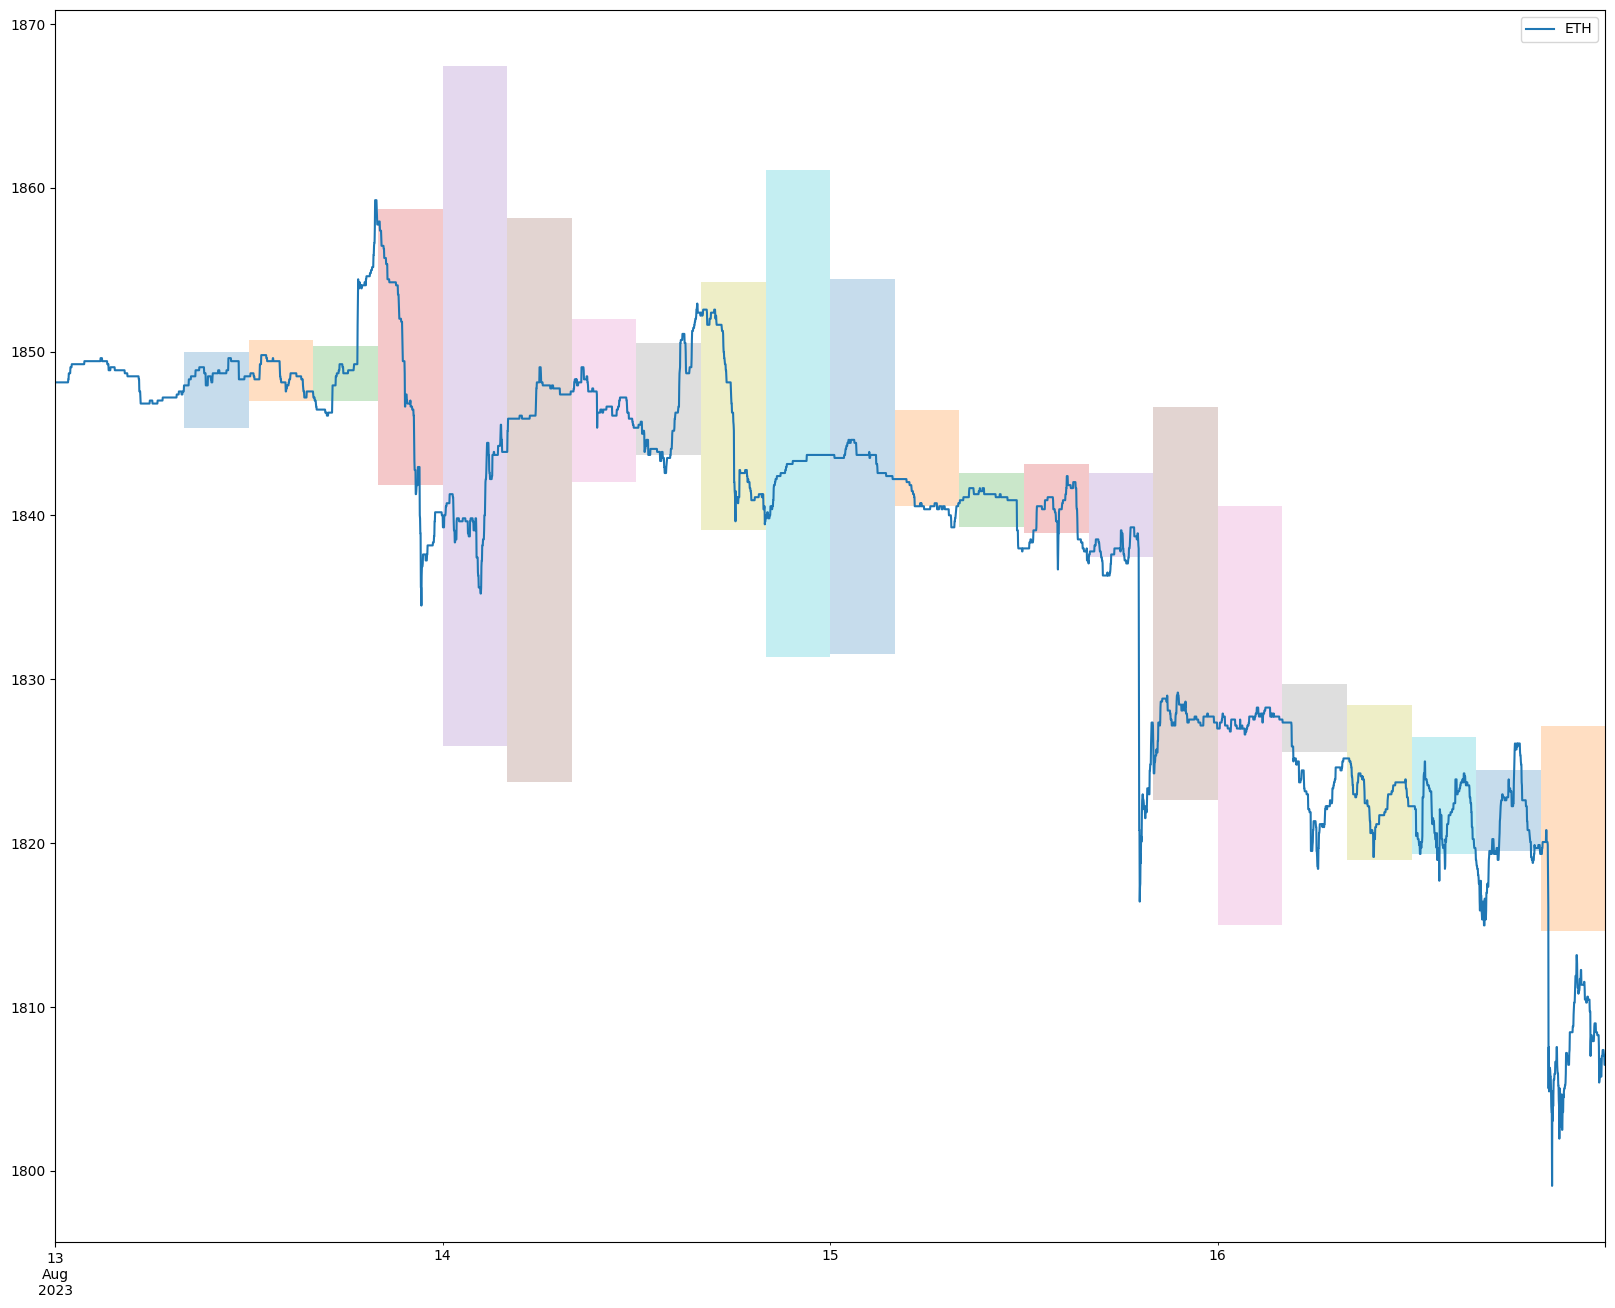

                                              NoProvisionStrategy                 UniswapV2Strategy          ConstantIntervalStrategy IntervalsAroundtheCurrentPriceStrategy TwoIntervalsAroundtheCurrentPriceStrategy                     FillUpStrategy             MovingAverageStrategy            BollingerBrandsStrategy
max_draw_down                     0.01644353622010012701286054980   0.01648916071691314571186581947   0.01628113682860419519036622629        0.01753133823523225081129432254           0.01485382080147425344594458106    0.01624340685553211076704246991   0.01586581471656462856810596668    0.01515486246812650587895484876
annualized_returns                -0.6493587078601149829291505310   -0.6498866744593052851273569897   -0.6452207726980603026425638803        -0.6208893890969941312783457481           -0.5650670109876484275186375251    -0.5661893036932584968914157493   -0.6238555038461174340736299303    -0.5930549943375551138124932254
net_value                          0.988580

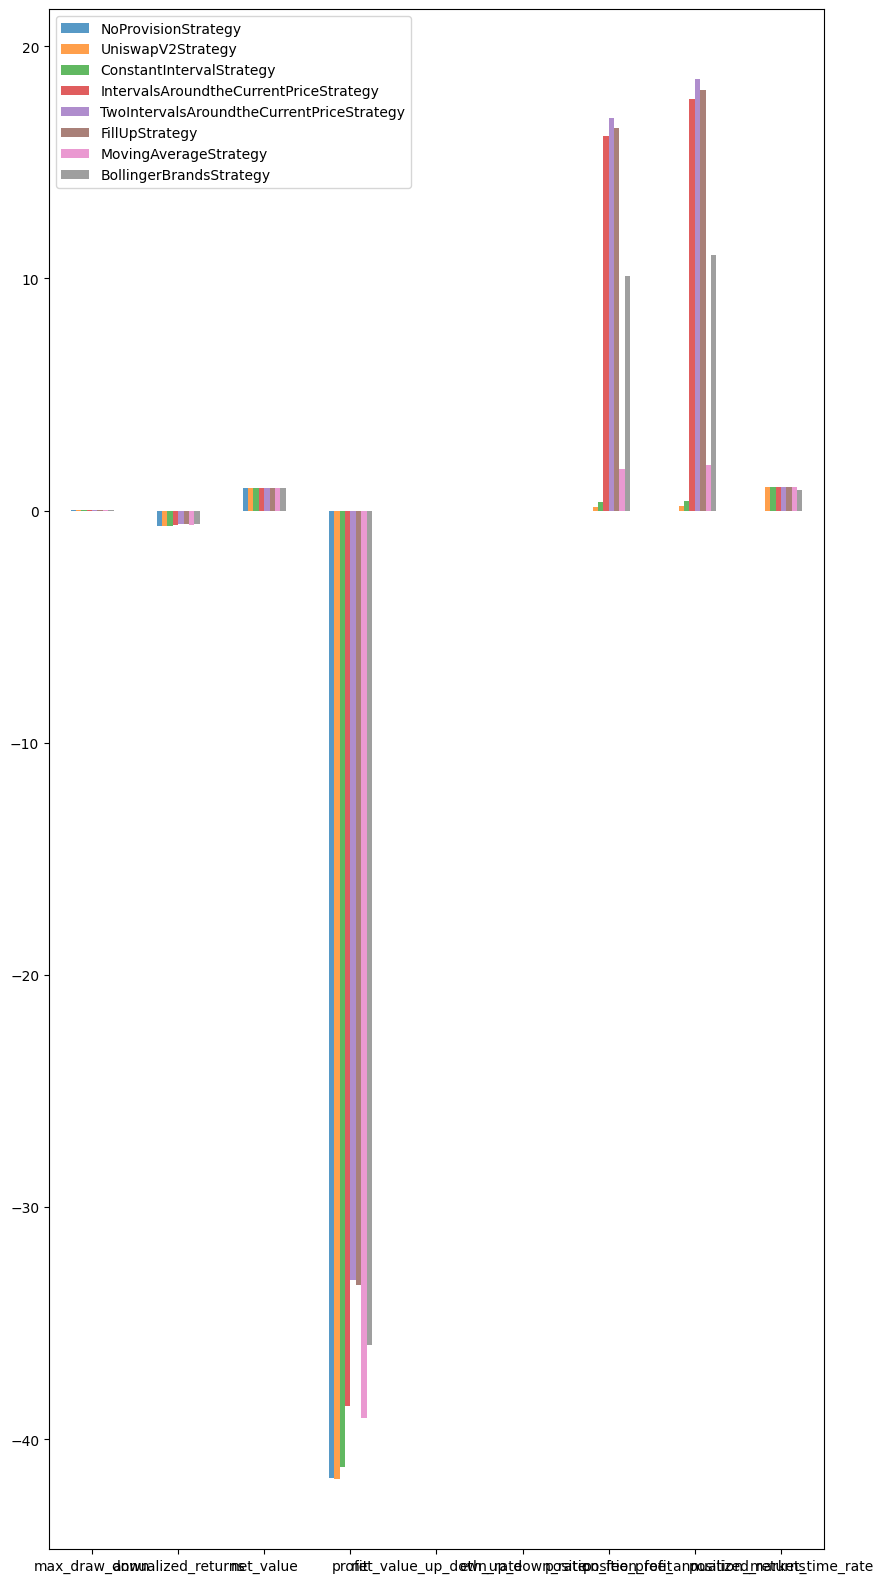

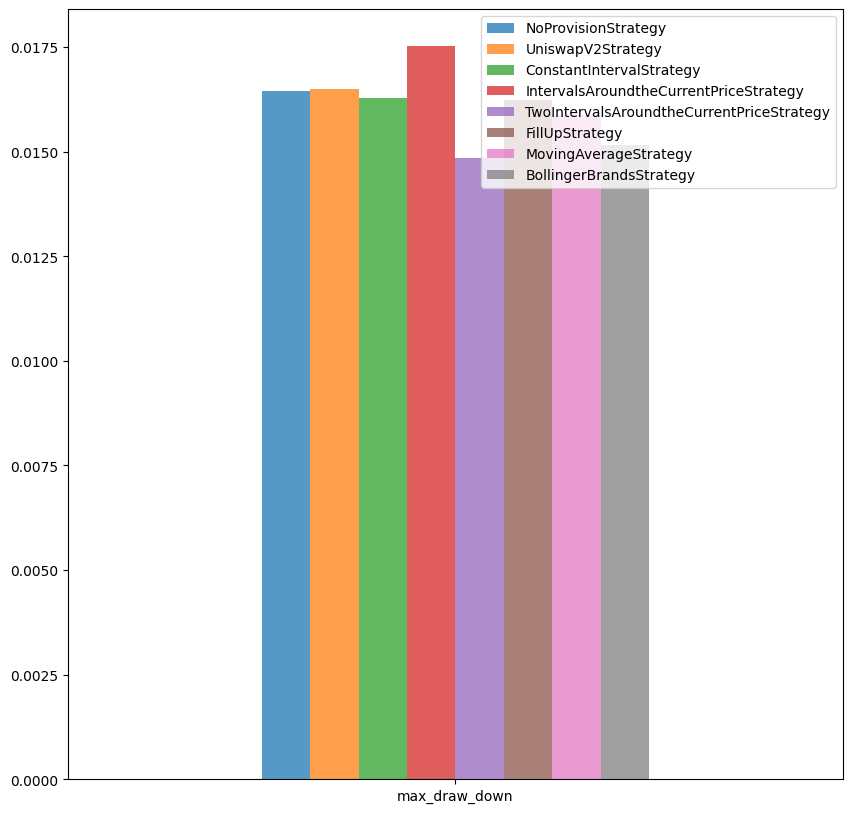

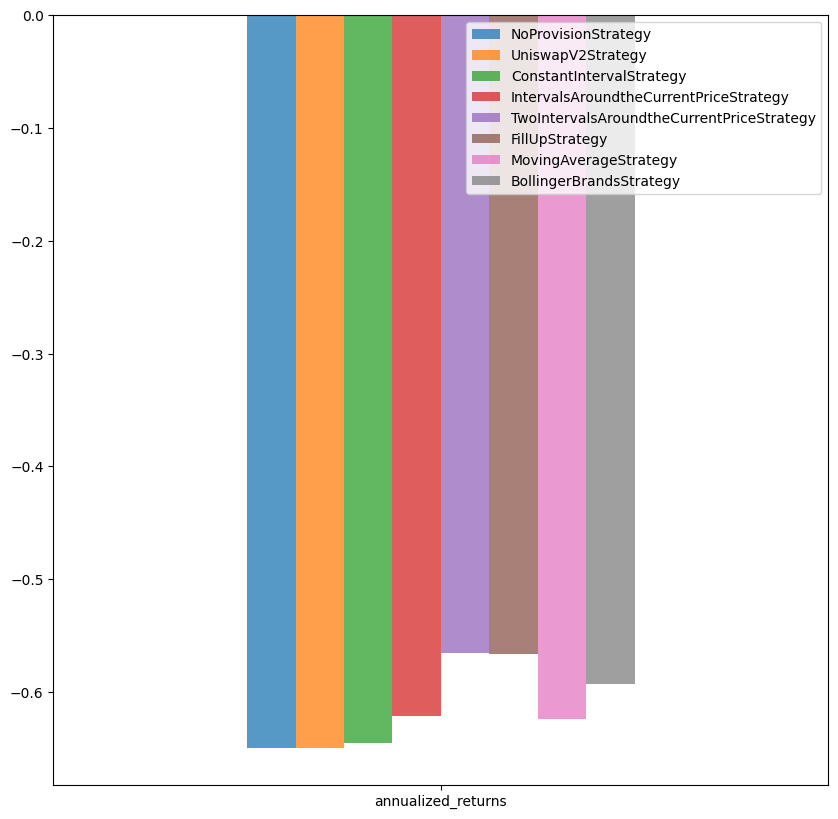

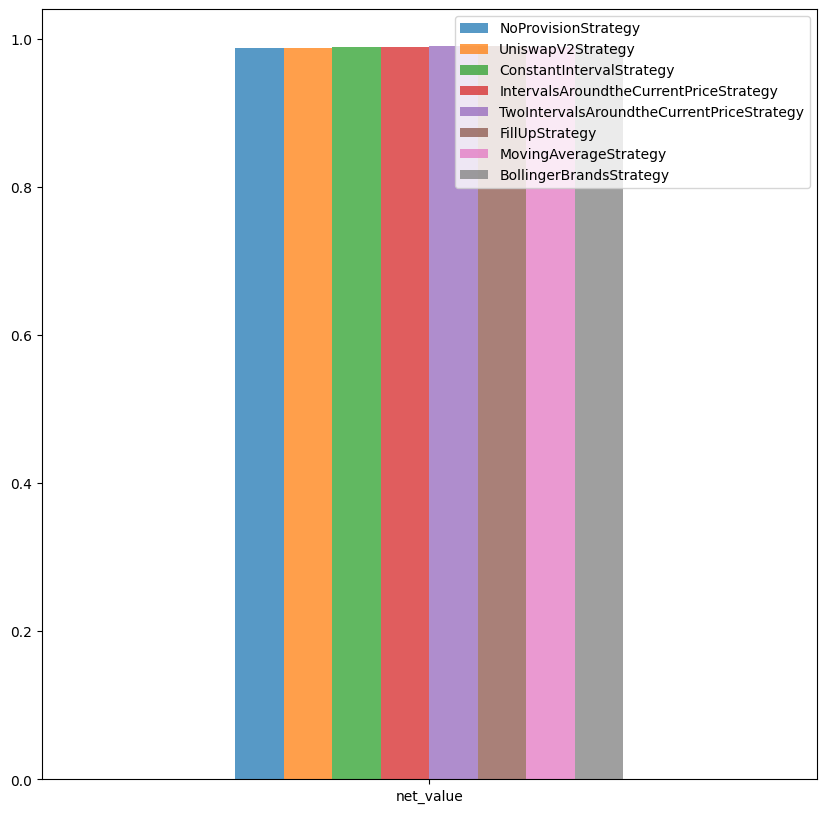

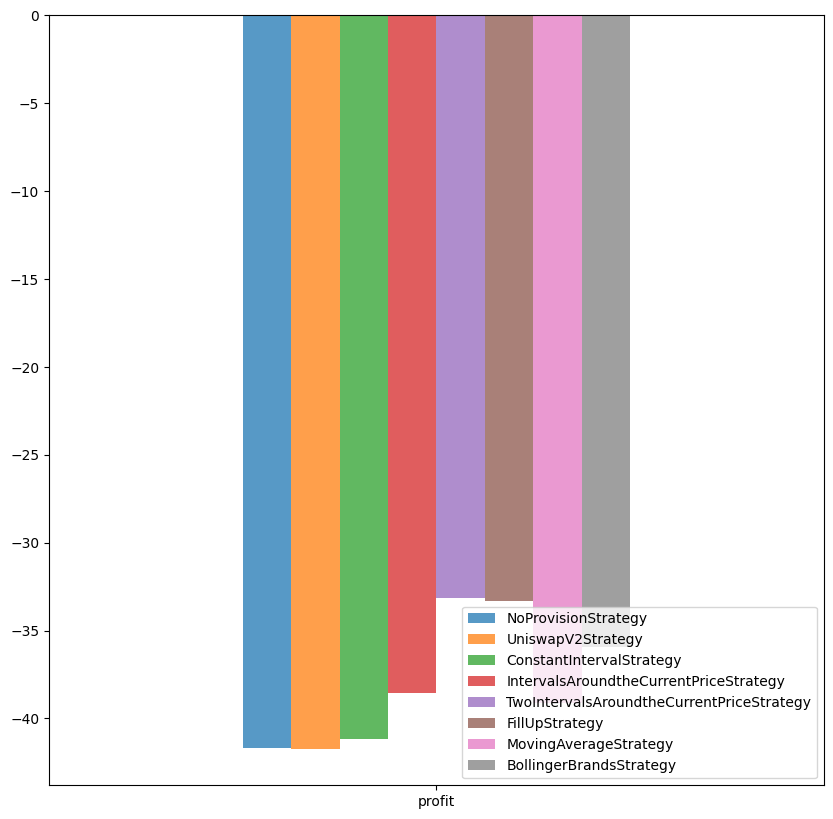

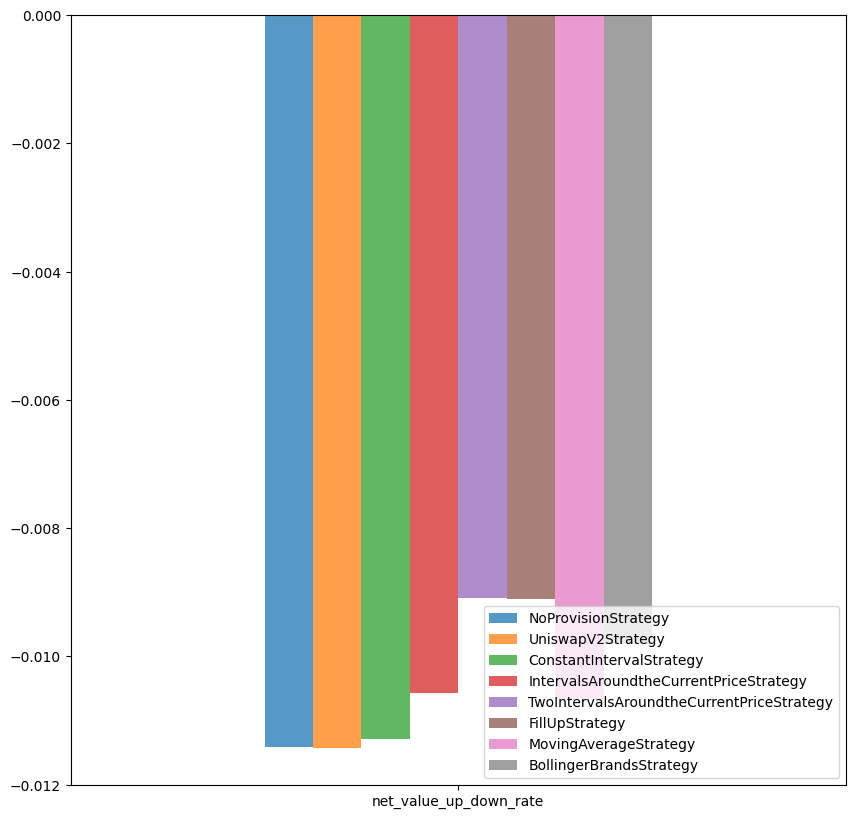

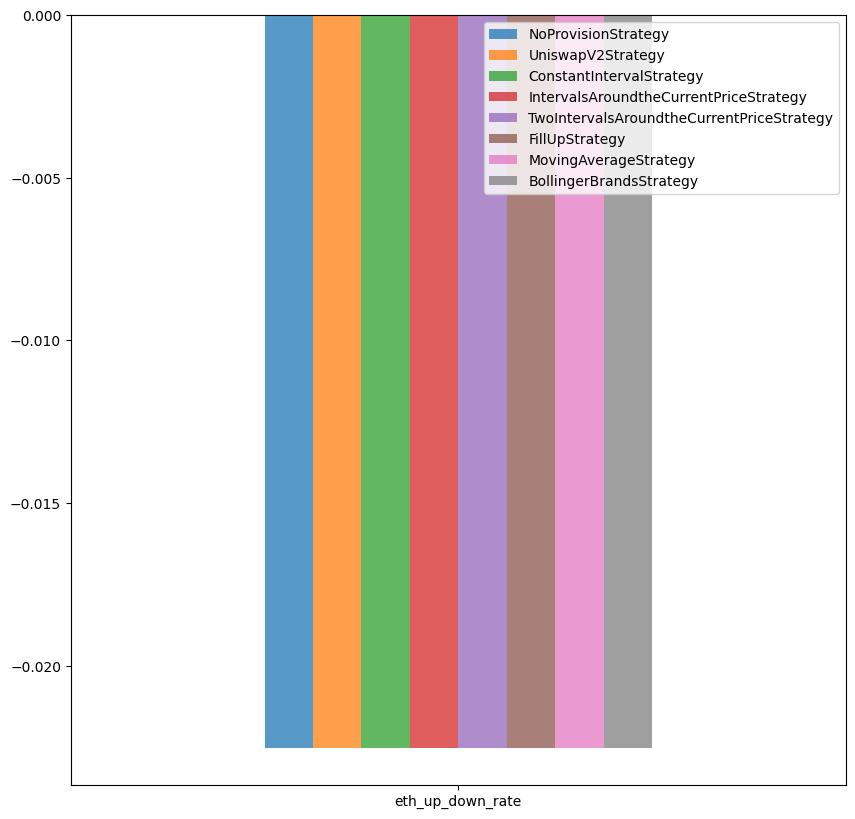

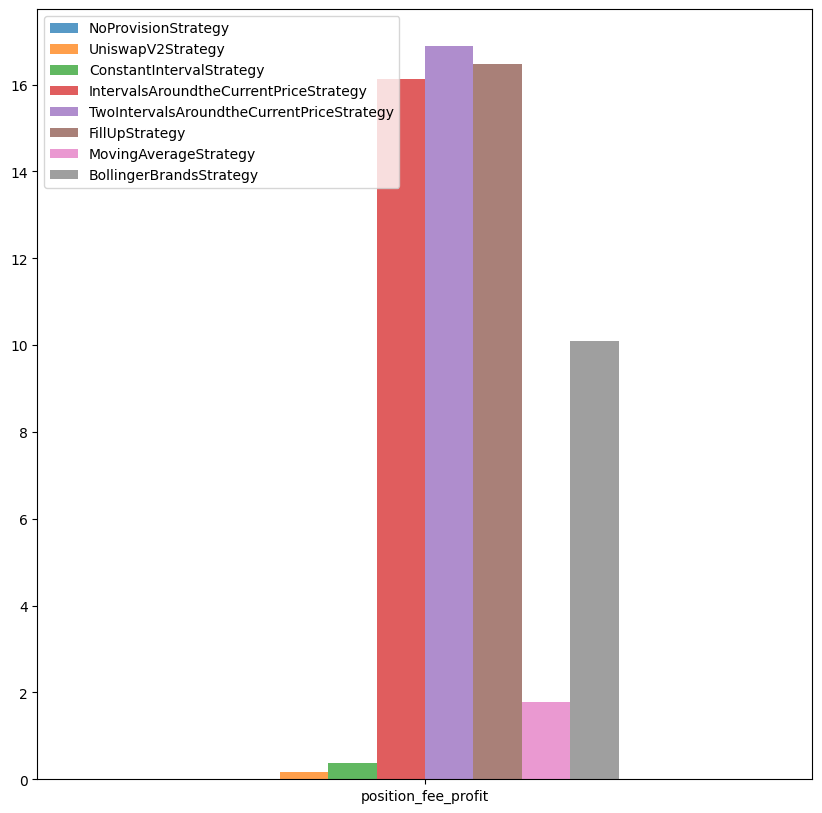

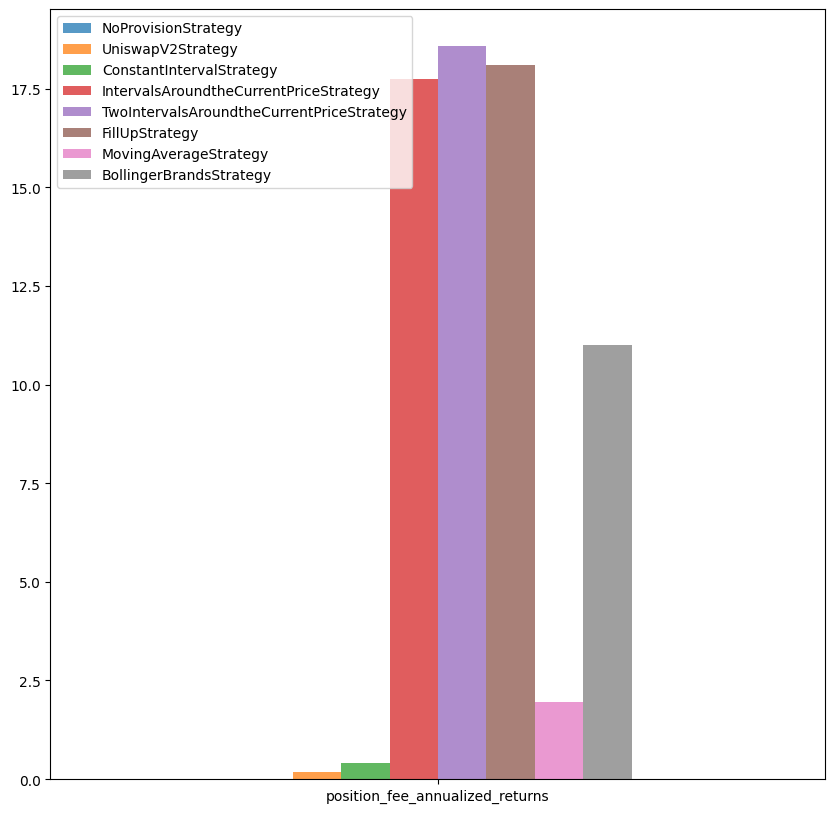

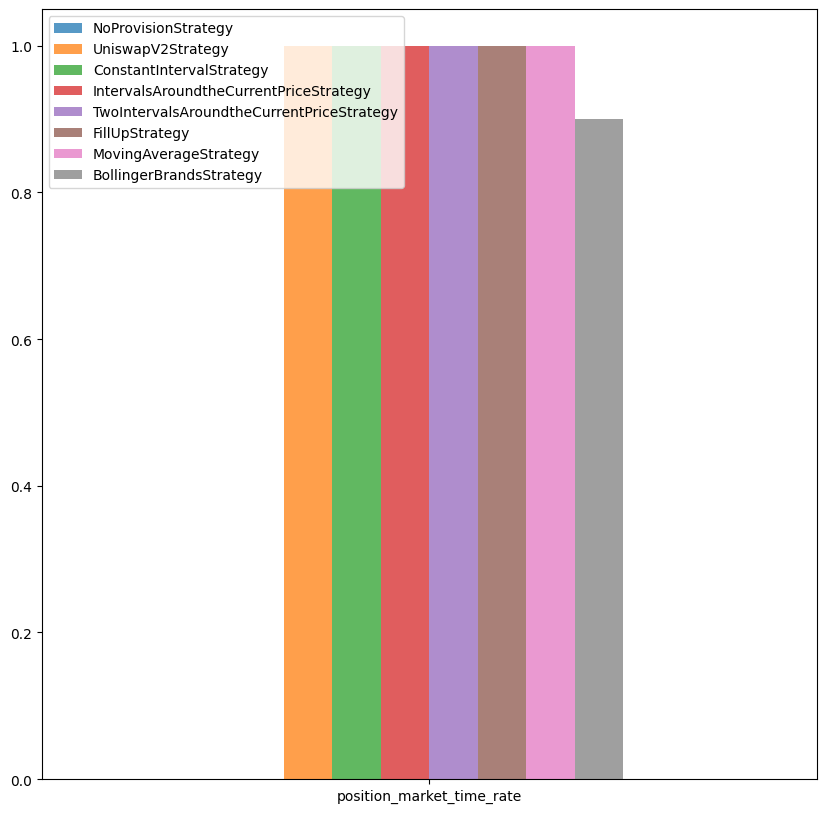

In [4]:
import math
from datetime import date, datetime, timedelta
from _decimal import Decimal
from typing import List, Dict
import pandas as pd
from matplotlib.pylab import plt
import matplotlib.dates as mdates

from demeter import TokenInfo, Actuator, Strategy, RowData, ChainType, MarketInfo, AtTimeTrigger, EvaluatorEnum, \
    PeriodTrigger, simple_moving_average, realized_volatility, BaseAction
from demeter.broker import AccountStatus, ActionTypeEnum
from demeter.uniswap import UniV3Pool, UniLpMarket
from demeter.uniswap.helper import tick_to_base_unit_price

pd.options.display.max_columns = None
pd.set_option("display.width", 5000)
c = 2


def plotter(account_status_list: List[AccountStatus]):
    net_value_ts = [status.net_value for status in account_status_list]
    time_ts = [status.timestamp for status in account_status_list]
    plt.plot(time_ts, net_value_ts)
    plt.show()


def plot_position_return_decomposition(account_status: pd.DataFrame, price: pd.Series, market: MarketInfo):
    fig, value_ax = plt.subplots()
    day = mdates.DayLocator(interval=2)

    price_ax = value_ax.twinx()
    price_ax.xaxis.set_major_locator(day)
    price_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    value_ax.set_xlabel('time')
    value_ax.set_ylabel('value', color='g')
    price_ax.set_ylabel('price', color='b')

    net_value_ts = list(account_status.net_value)
    time_ts = list(account_status.index)
    price_ts = list(price)

    value_in_position = account_status[market.name + "_net_value"]
    value_in_account = account_status["USDC"] + account_status["ETH"] * price

    value_ax.plot(time_ts, net_value_ts, 'g-', label="net value")
    value_ax.plot(time_ts, value_in_position, 'r-', label="value in get_position")
    value_ax.plot(time_ts, value_in_account, 'b-', label="value in broker account")
    price_ax.plot(time_ts, price_ts, 'y-', label="price")
    fig.legend()
    fig.show()


def calc_pair_price_by_sqrt(sqrt, decimal0=6, decimal1=18, base0=True):
    price = Decimal(sqrt) ** 2 / 2 ** 192 * Decimal(10 ** decimal0 - decimal1)
    return price if not base0 else 1 / price


def get_positions_info(actions, prices):
    positions = {}
    for action in actions:
        if action.action_type == ActionTypeEnum.uni_lp_add_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key not in positions:
                positions[key] = {'start': action.timestamp}
        if action.action_type == ActionTypeEnum.uni_lp_remove_liquidity:
            key = f'{action.position.lower_tick}_{action.position.upper_tick}'
            if key in positions and action.remain_liquidity == 0:
                positions[key]['end'] = action.timestamp
    df_price = prices.copy(deep=True)
    df_price[eth.name] = df_price[eth.name].astype(float)
    df_price.plot(y=eth.name, kind='line', figsize=(20, 16))
    for key, position in positions.items():
        tick_lower, tick_upper = list(map(int, key.split('_')))
        price_upper = tick_to_base_unit_price(tick_lower, usdc.decimal, eth.decimal, market._is_token0_quote)
        price_lower = tick_to_base_unit_price(tick_upper, usdc.decimal, eth.decimal, market._is_token0_quote)
        if 'end' not in position:
            position['end'] = list(df_price.index)[-1]
        plt.fill_between([position['start'], position['end']], y1=price_lower, y2=price_upper, alpha=.25)
    plt.show()


class NoProvisionStrategy(Strategy):
    def initialize(self):
        """
        Initialize function will be called right before a backtest start.
        You can do various things here, e.g. register a trigger, or add a simple moving average line.
        """
        new_trigger = AtTimeTrigger(  # define a new trigger
            time=datetime(2022, 8, 20, 12, 0, 0), do=self.work  # we will make the action happen at 12:00 20/8/22
        )  # This is a callback function, defines what to do at this time.
        self.triggers.append(new_trigger)  # Register our trigger

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        pass


class UniswapV2Strategy(Strategy):
    def initialize(self):
        """
        Initialize function will be called right before a backtest start.
        You can do various things here, e.g. register a trigger, or add a simple moving average line.
        """
        new_trigger = AtTimeTrigger(  # define a new trigger
            time=datetime(2023, 8, 13, 0, 0, 0), do=self.work
        )  # This is a callback function, defines what to do at this time.
        self.triggers.append(new_trigger)  # Register our trigger

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        lp_market: UniLpMarket = self.markets[market_key]  # pick our market.
        lp_market.add_liquidity_by_tick(-887272, 887272)  # add liquidity
        pass


class ConstantIntervalStrategy(Strategy):
    def __init__(self, a=100):
        super().__init__()
        self.a = a

    def initialize(self):
        new_trigger = AtTimeTrigger(  # define a new trigger
            time=datetime(2023, 8, 13, 0, 0, 0), do=self.work
        )  # This is a callback function, defines what to do at this time.
        self.triggers.append(new_trigger)  # Register our trigger

    def work(self, row_data: RowData):
        """
        When time is up, work function will be called.
        """
        market: UniLpMarket = self.markets[market_key]
        init_price = market.market_status.data.price
        market.even_rebalance(init_price)  # rebalance all reserve token#
        market.add_liquidity(init_price - self.a, init_price + self.a)


class IntervalsAroundtheCurrentPriceStrategy(Strategy):
    def __init__(self, a=10, b=1, update_interval=timedelta(days=1)):
        super().__init__()
        self.a = a
        self.b = b

    def initialize(self):
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def init_work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        current_price = lp_market.market_status.data.price
        lp_market.add_liquidity(current_price - self.a, current_price + self.a)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        current_price = row_data.prices[eth.name]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])

        lp_market.add_liquidity(current_price - self.a, current_price + self.a)


class TwoIntervalsAroundtheCurrentPriceStrategy(Strategy):
    def __init__(self, a=10, b=1, update_interval=timedelta(days=1)):
        super().__init__()
        self.a = a
        self.b = b

    def initialize(self):
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def init_work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        init_price = lp_market.market_status.data.price

        lp_market.add_liquidity(init_price - self.a, init_price + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(init_price - self.b, init_price)
        else:
            lp_market.add_liquidity(init_price, init_price + self.b)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]

        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])

        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(row_data.prices[eth.name] - self.b, row_data.prices[eth.name])
        else:
            lp_market.add_liquidity(row_data.prices[eth.name],
                                    row_data.prices[eth.name] + row_data.prices[eth.name] + self.b)


class FillUpStrategy(Strategy):
    def __init__(self, a=10):
        super().__init__()
        self.a = a

    def initialize(self):
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(days=1), do=self.work))

    def init_work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        init_price = lp_market.market_status.data.price

        lp_market.even_rebalance(init_price)  # rebalance all reserve token#
        lp_market.add_liquidity(init_price - self.a, init_price + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(init_price - self.a, init_price)
        else:
            lp_market.add_liquidity(init_price, init_price + self.a)

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        lp_market.add_liquidity(row_data.prices[eth.name] - self.a, row_data.prices[eth.name] + self.a)
        if self.broker.assets[market.base_token].balance > 0:
            lp_market.add_liquidity(row_data.prices[eth.name] - self.a, row_data.prices[eth.name])
        else:
            lp_market.add_liquidity(row_data.prices[eth.name], row_data.prices[eth.name] + self.a)


class MovingAverageStrategy(Strategy):

    def __init__(self, price_width=100):
        super().__init__()
        self.price_width = price_width

    def initialize(self):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        self.add_column(lp_market, "ma5", simple_moving_average(self.data.default.price, timedelta(hours=4)))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(hours=8), trigger_immediately=True, do=self.work))

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        ma_price = row_data.market_status.default.ma5 if row_data.market_status.default.ma5 > 0 else row_data.prices[
            eth.name]
        lp_market.add_liquidity(ma_price - self.price_width, ma_price + self.price_width)


class BollingerBrandsStrategy(Strategy):
    """
    We will provide liquidity inside the Bollinger Bands.
    These bands are made up of a lower band BOLL = pa − c · v
    and an upper band BOLU = pa + c · v.
    The liquidity get_position will be [pa − v · c, pa + v · c].

    * pa is simple moving average
    * c is a constant value, =2
    * v is volatility

    we will adjust liquidity every 4 hours, by remove all the liquidity, then even split all the capital into two assets,
    and provide liquidity by the rules above.

    """

    def initialize(self):
        self.add_column(market_key, "sma_1_day", simple_moving_average(self.data[market_key].price, timedelta(hours=4)))
        self.add_column(market_key, "volatility",
                        realized_volatility(self.data[market_key].price, timedelta(hours=4), timedelta(hours=4)))
        self.triggers.append(AtTimeTrigger(time=datetime(2023, 8, 13, 0, 0, 0), do=self.init_work))
        self.triggers.append(PeriodTrigger(time_delta=timedelta(hours=4), trigger_immediately=True, do=self.work))

    def init_work(self, row_data: RowData):
        self.markets.default.even_rebalance(self.data[market_key].price[0])

    def work(self, row_data: RowData):
        lp_market: UniLpMarket = self.broker.markets[market_key]
        lp_row_data = row_data.market_status[market_key]
        if len(lp_market.positions) > 0:
            lp_market.remove_all_liquidity()
            lp_market.even_rebalance(row_data.prices[eth.name])
        if math.isnan(lp_row_data.volatility):
            return
        limit = c * float(row_data.prices[eth.name]) * lp_row_data.volatility
        lp_market.add_liquidity(lp_row_data.sma_1_day - limit, lp_row_data.sma_1_day + limit)


# Declare a token, and it's name will be used as unit of amounts.
usdc = TokenInfo(name="usdc", decimal=6)  # declare token usdc
eth = TokenInfo(name="eth", decimal=18)  # declare token eth
# Declare an Uniswap V3 pool. We will set the parameters according to the real pool on chain.
pool = UniV3Pool(token0=usdc, token1=eth, fee=0.05, base_token=usdc)

# Declare a market key, which will be used to find the corresponding market in broker
market_key = MarketInfo("uni_market")
# Declare the market,
market = UniLpMarket(market_key, pool)  # uni_market:UniLpMarket, positions: 0, total liquidity: 0
# load data for market. those data is prepared by download tool
market.data_path = "../data"  # set data path
market.load_data(
    chain=ChainType.polygon.name,  # load data
    contract_addr="0x45dda9cb7c25131df268515131f647d726f50608",
    start_date=date(2023, 8, 13),
    end_date=date(2023, 8, 16),
)

# Declare the Actuator, which controls the whole process
actuator = Actuator()  # declare actuator, Demeter Actuator (broker:assets: ; markets: )
# add market to broker
actuator.broker.add_market(market)
# Initial some fund to broker.
actuator.broker.set_balance(usdc, 1800)
actuator.broker.set_balance(eth, 1)
# Set strategy to actuator
actuator.strategy = NoProvisionStrategy()  # set strategy to actuator
# Set price. Those price will be used in all markets.
# Usually, you will have to find the price list from outer source.
# Luckily, uniswap pool data contains price information. So UniLpMarket provides a function to retrieve price list.
actuator.set_price(market.get_price_from_data())
# run test, If you use default parameter, final fund status will be printed in console.
evaluator = [
    EvaluatorEnum.max_draw_down,
    EvaluatorEnum.annualized_returns,
    EvaluatorEnum.net_value,
    EvaluatorEnum.profit,
    EvaluatorEnum.net_value_up_down_rate,
    EvaluatorEnum.eth_up_down_rate,
    EvaluatorEnum.position_fee_profit,
    EvaluatorEnum.position_fee_annualized_returns,
    EvaluatorEnum.position_market_time_rate,
]
evaluating_results = []
pd_columns = []
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = UniswapV2Strategy()
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = ConstantIntervalStrategy(a=400)
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = IntervalsAroundtheCurrentPriceStrategy()
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = TwoIntervalsAroundtheCurrentPriceStrategy(400, 200)
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = FillUpStrategy()
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = MovingAverageStrategy()
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

actuator.reset()

actuator.strategy = BollingerBrandsStrategy()
actuator.run(evaluator=evaluator)
actuator.save_result(
    path="./result",  # save path
    account=True,  # save account status list as a csv file
    actions=True,  # save actions as a json file and a pickle file
)
pd_columns.append(type(actuator.strategy).__name__)
evaluating_results.append(actuator.evaluating_indicator)
plot_position_return_decomposition(actuator.get_account_status_dataframe(), actuator.token_prices[eth.name], market_key)
get_positions_info(actuator.actions, actuator.token_prices)

df = pd.DataFrame(evaluating_results)
df2 = df.T
df2.columns = pd_columns
print(df2)
for item in pd_columns:
    df2[item] = pd.to_numeric(df2[item])
df2.plot(kind='bar', alpha=0.75, rot=0, figsize=(10, 20))
plt.show()
for index in list(df2.index):
    df3 = df2[df2.index.isin([index])]
    df3.plot(kind='bar', alpha=0.75, rot=0, figsize=(10, 10))
    plt.show()